# Disclaimer

Esta nb es exactamente la misma que la de train_v4_VF con la diferencia de que vamos a probar de hacer el .fit() del modelo usando tambien los grupos de baja presencialidad, es decir que NO haremos ese filtro para train pero si para test ya que si bien es verdad que solo nos interesa scorear bien los grupos de alta presen, queremos probar si la performance de dicho scoreo se ve afectada de cierta manera o no, por incluir en el fit los grupos de baja. Es por esto que en esta nb vamos a eliminar codigo relacionado a la exploracion ya que solo nos interesa el procesamiento/limpieza para este usecase

# Setup

## Librerías, modulos y configuración de la notebook 

In [2]:
#!pip install catboost

In [3]:
#### Librerías y modulos ####
import pandas as pd
import numpy as np
import seaborn as sns
import os,json
import matplotlib.pyplot as plt
import sklearn
from pandas.io import gbq
from datetime import datetime
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import sys
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()),'src/'))
from funcs_cotizador import *

In [4]:
#### Configuraciones de la notebook ####
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
#pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [5]:
#### Parametros de la notebook ####
path_save = '../datos/'
# actualizado al 04/19
dolar_blue = 197
dolar_oficial = 119.28

## Load data

In [6]:
# Upload del pickle generado en la notebook "make_data"
df = pd.read_pickle('{}df_meli_2022-05-04.pkl'.format(path_save))

In [7]:
df.shape

(832016, 42)

# Data Cleaning/Preprocessing 

### *Eliminar nulos*

In [8]:
old_shape = df.shape[0]
df = df.dropna(subset=['car_year','car_kms','match_marca_a','match_modelo_a','match_v1_a','Subseg_a', 'Seg_a'])
print(f'Hey! {old_shape - df.shape[0]} were removed due to null values')
old_shape = df.shape[0]

Hey! 1011 were removed due to null values


### *Eliminar duplicados*

In [9]:
# Tratamiento de la feautre "runtime"
df['runtime'] = pd.to_datetime(df.runtime.apply(lambda x: str(x)[:19]))
df = df.sort_values(['runtime'])
# Ahora si, teniendo el df ordenado, eliminamos los duplicados, quedandonos con el registro más reciente (la última ocurrencia)
df.drop_duplicates(subset=['car_id'], keep='last', inplace=True)

In [10]:
df.shape

(129823, 42)

### *Eliminar 11111 & 999999*

**Dropeamos valores como 111111 o 999999 (ya sean outliers o no)** --> ESTO HAY QUE SUMARLO AL PROCESAMIENTO DE LAS SIMULACIONES !!! <br> 
* Pueden existir casos donde estos valores extraños no sean outliers, por lo tanto no los vamos a conseguir limpiar cuando dropiemos outliers. Es por eso que desarrollamos el siguiente metodo
* Es clave hacerlo en este momento sobre "price_amount" y no luego sobre "price_meli_ok" ya que hay casos en los que el price simbol es USD y luego cuando lo multiplicamos por el TC para pasar a "price_meli_ok" dejan de cumplir estas condiciones de ser 111111 o 999999 y les perdemos el rastro

In [11]:
df['price_amount'] = df.price_amount.astype('int')

In [12]:
m1 = df.price_amount == 1111
m2 = df.price_amount == 11111
m3 = df.price_amount == 111111
m4 = df.price_amount == 1111111
m5 = df.price_amount == 11111111
m6 = df.price_amount == 111111111

len(df[m1 | m2 | m3 | m4 | m5 | m6])

42

In [13]:
# observamos
df[m1 | m2 | m3 | m4 | m5 | m6][['price_amount']].head()

,price_amount
3858,11111111
255717,11111111
212540,111111111
102200,1111111
29468,111111111


In [14]:
df.shape

(129823, 42)

In [15]:
# dropeamos
df = df[~(m1 | m2 | m3 | m4 | m5 | m6)]

In [16]:
df.shape

(129781, 42)

*Ahora lo mismo pero para los casos 999999*

In [17]:
m1 = df.price_amount == 9999
m2 = df.price_amount == 99999
m3 = df.price_amount == 999999
m4 = df.price_amount == 9999999
m5 = df.price_amount == 99999999

len(df[m1 | m2 | m3 | m4 | m5])

87

In [18]:
# observamos
df[m1 | m2 | m3 | m4 | m5 | m6][['price_amount']].head()

,price_amount
5973,99999999
89773,9999999
103868,999999
42914,999999
31525,9999999


In [19]:
df.shape

(129781, 42)

In [20]:
# dropeamos
df = df[~(m1 | m2 | m3 | m4 | m5)]

In [21]:
df.shape

(129694, 42)

*Ahora lo mismo para kms*

In [22]:
df['car_kms'] = df.car_kms.astype('int')

In [23]:
df[df.car_kms > 0]['car_kms'].min()

1

In [24]:
m1 = df.car_kms == 1
m2 = df.car_kms == 11
m3 = df.car_kms == 111
m4 = df.car_kms == 1111
m5 = df.car_kms == 11111
m6 = df.car_kms == 111111
m7 = df.car_kms == 1111111
m8 = df.car_kms == 11111111

len(df[ m1 | m2 | m3 | m4 | m5 | m6 | m7 | m8])

806

In [25]:
# observamos
df[m1 | m2 | m3 | m4 | m5 | m6 | m7 | m8][['car_kms']].head()

,car_kms
2799,1111
1177,111111
7810,11111
8492,11111
211741,111111


In [26]:
df.shape

(129694, 42)

In [27]:
# dropeamos
df = df[~(m1 | m2 | m3 | m4 | m5 | m6 | m7 | m8)]

In [28]:
df.shape

(128888, 42)

*Lo mismo pero para los valores 99999*

In [29]:
m1 = df.car_kms == 999
m2 = df.car_kms == 9999
m3 = df.car_kms == 99999
m4 = df.car_kms == 999999
m5 = df.car_kms == 9999999

len(df[m1 | m2 | m3 | m4 | m5])

77

In [30]:
# observamos
df[m1 | m2 | m3 | m4 | m5][['car_kms']].head()

,car_kms
252610,99999
252092,999
17358,999999
80507,999999
90932,999999


In [31]:
df.shape

(128888, 42)

In [32]:
# dropeamos
df = df[~(m1 | m2 | m3 | m4 | m5)]

In [33]:
df.shape

(128811, 42)

In [34]:
# checkpoint
df.to_csv('{}df_checkpoint_1.pkl'.format(path_save))

In [35]:
df = pd.read_csv('{}df_checkpoint_1.pkl'.format(path_save))
df.shape

(128811, 43)

### *Precio final*

In [36]:
#Dropeamos los precios en dolares** --> Al final no lo hicimos
#Representan un 14% de la base !!! Caía mucho el test sin estos casos
# observamos su volumen
mask = df.price_symbol == 'U$S'
display(df[mask].shape)
display(round(df[mask].shape[0]/len(df),2))
# dropeamos
df.drop(list(df[mask].index),axis=0,inplace=True)
display(df.shape)

(14614, 43)

0.11

(114197, 43)

In [37]:
df.rename(columns={'price_amount':'price_meli_ok'},inplace=True)

In [38]:
# # Construcción del precio final
# blue= dolar_blue
# oficial= dolar_oficial
# col1 = 'price_symbol'
# col2 = 'car_kms'
# conditions = [df[col1]!='U$S', (df[col1]=='U$S') & (df[col2]==0), (df[col1]=='U$S') & (df[col2]!=0)]
# choices = [df.price_amount, df['price_amount']*oficial, df['price_amount']*blue]

# df['price_meli_ok'] = np.select(conditions, choices, default=np.nan)

### *Dropeamos 0kms y concesionaria*

In [39]:
df['dealer'] = np.where(df['dealer']==True,1,0)
mask_not_0km = df.car_kms > 90
mask_not_conces = df.dealer == 0

df = df[(mask_not_0km) & (mask_not_conces)]

In [40]:
df.shape

(49961, 43)

### *Dropeamos match_score por debajo de 80%*

In [41]:
lst = ['score_marca_a','score_modelo_a','score_v1_c']
for col in lst:
    df = df[df[col]>=80]
    
# chequeo
df[lst].min()

score_marca_a     92
score_modelo_a    86
score_v1_c        80
dtype: int64

In [42]:
df.shape

(40332, 43)

### *Dropeamos registros que no sean de los ultimos 15 días*

In [43]:
df.runtime.max()

'2022-04-18 23:01:25'

In [44]:
from datetime import date, datetime, timedelta

In [45]:
df['runtime'] = df['runtime'].apply(pd.to_datetime)

In [46]:
df[['runtime','price_meli_ok']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40332 entries, 2 to 128810
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   runtime        40332 non-null  datetime64[ns]
 1   price_meli_ok  40332 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 945.3 KB


In [47]:
max_date = df.runtime.max()
mask_last15d = (df.runtime <= max_date) & ((df.runtime >= max_date - timedelta(days=15)))
df = df[mask_last15d]

In [48]:
df.runtime.max()

Timestamp('2022-04-18 23:01:25')

In [49]:
print(df.runtime.min())
print(df.runtime.max())

2022-04-04 00:00:30
2022-04-18 23:01:25


In [50]:
df.shape

(37713, 43)

### *Dropeamos categorías que no nos sirven*  --> Esto es lo que vamos a skipear (solamente en train) en esta nb!

*Las categorías que dejamos afuera, son las que no nos interesa cotizar porque irán a reglas o al equipo de pricing*

Los grupos de los escenarios los vamos a re-definir aca. Debido a que cuando lo hicimos en la nb "Tres escenarios" como un primer apporach estaba bien y aparte el objetivo era validar la hipotesis de outliers vs presencia. Pero ocurre que aca el procesamiento es más profundo, y por lo tanto un auto que capas estaba en el grupo 4 en la nb "Tres Escenarios" aca debido a las limpiezas extra respesto a esa nb, pierden muchisimo volumen y quedaría en grupos muchísimos más bajos que no entrarían para el algoritmo. El caso perfecto es la F-150 de FORD: en ese caso en la nb "Tres Esce" quedaba en el grupo 4, y aca desp de todo el procesamiento nos queda 1 solo caso el cual se nos fue a test despues de split y en train no estaba, por lo tanto tira error la funcion de data_processing_1().

In [51]:
#df_grouped = df.groupby(['match_marca_a','match_modelo_a','match_v1_a'],as_index=False).size()
#df_grouped.columns = ['marca','modelo','version','cant']
#df_grouped.sort_values(by='cant',ascending=False,inplace=True)

In [52]:
#df_grouped.head(10)

In [53]:
#df_grouped.tail(10)

In [54]:
#mask = df_grouped['marca'] == 'VOLKSWAGEN'
#df_grouped[mask].sort_values(by='modelo')

In [55]:
# agrupacion
#df_grouped = df.groupby(['match_marca_a','match_modelo_a','match_v1_a'],as_index=False).size()
#df_grouped.columns = ['marca','modelo','version','cant']
#df_grouped.sort_values(by='cant',ascending=False,inplace=True)

# deciles
#df_output = df_grouped.copy()

#data = df_grouped.copy()
#data.sort_values(by='cant',ascending=False,inplace=True)

#data['cuantiles' + str('_'+'cant')] =pd.qcut(data['cant'], 10, duplicates='drop')

#placeholder= 'marca'
#tmp = data.groupby('cuantiles' + str('_'+'cant')).agg({placeholder:'count'}).rename(columns={placeholder:'placeholder'})
#leni = len(tmp)
#tmp['cuantil' + str('_'+'cant')] = list(reversed(list(np.arange(1,leni+1,1))))
#tmp['bin' + str('_'+'cant')] = tmp.index
#tmp.reset_index(drop=True,inplace=True)
#tmp.drop('placeholder',1,inplace=True)

#data = data.merge(tmp, how='inner',left_on=['cuantiles' + str('_'+'cant')], right_on='bin' + str('_'+'cant'))

#data.drop(cols_to_drop,1,inplace=True)

#df_output = df_output.merge(data, on=['marca','modelo','version'])

# seleccion y orden final de las columnas del output
#df_output_ok = df_output[['marca','modelo','version','cant','cuantil_cant','bin_cant']]
#df_output_ok.sort_values(by='cant',ascending=False,inplace=True)
#df_output_ok.head()

In [56]:
#data.drop('cuantiles_cant',1,inplace=True)

In [57]:
#data.version.nunique()

In [58]:
#asd = (data.groupby('cuantil_cant')['cant'].sum()/sum(data.cant))*100
#asd

In [59]:
#tmp

In [60]:
# Escenario de cotizacion: Algoritmo
#print(f'Algoritmo: {asd.iloc[0:4].sum()}')
#print(f'Reglas: {asd.iloc[4:7].sum()}')
#print(f'Equipo Pricing: {asd.iloc[7:].sum()}')

In [61]:
# Marcas-modelos en cada grupo
#data['marca_modelo_version'] = data['marca'] + str(' - ') +data['modelo'] + str(' - ') + data['version']
#data.head()

In [62]:
#data[data.modelo == 'Tiggo']

In [63]:
#len(data) == data.marca_modelo_version.nunique()

In [64]:
# Marcas-modelo-versiones en cada grupo
#sorted(list(data[data['cuantil_cant']==1]['marca_modelo_version'].unique()))

In [65]:
#grupos_df = data.copy()
## nos quedamos únicamente con los grupos que entran al modelo
#grupos_df_algor = grupos_df[grupos_df['cuantil_cant'].apply(lambda x: x == 1)] # in [1,2,3]
## check
#grupos_df_algor.cuantil_cant.unique()

In [66]:
#grupos_df_algor.rename(columns={'cuantil_cant':'grupos'},inplace=True)

In [67]:
#grupos_df_algor.head()

In [68]:
#df_grupos = grupos_df_algor[['marca','modelo','version','marca_modelo_version', 'grupos']]

In [69]:
#df_grupos

In [70]:
#df_grupos.to_csv('{}df_grupos.csv'.format(path_save))

In [71]:
#marc_mod_vers_OK = list(df_grupos.marca_modelo_version.unique())
#len(marc_mod_vers_OK)

In [72]:
#pd.Series(marc_mod_vers_OK).to_csv('{}marc_mod_vers_OK.csv'.format(path_save))

In [73]:
# Nos quedamos unicamente con los marca-modelo-version dentro de los grupos 1, 2, 3 y 4
# marcas_ok = list(grupos_df_algor.marca.unique())
# modelos_ok = list(grupos_df_algor.modelo.unique())
# versiones_ok = list(grupos_df_algor.version.unique())
# guardamos las marcas_ok y los modelos_ok ya que son los únicos que nos van a interesar scorear
# pd.Series(marcas_ok).to_csv('{}marcas_ok.csv'.format(path_save))
# pd.Series(modelos_ok).to_csv('{}modelos_ok.csv'.format(path_save))
# pd.Series(versiones_ok).to_csv('{}versiones_ok.csv'.format(path_save))
# mask1 = df.match_marca_a.apply(lambda x: x in marcas_ok)
# mask2 = df.match_modelo_a.apply(lambda x: x in modelos_ok)
# mask3 = df.match_v1_a.apply(lambda x: x in versiones_ok)

#old_shape = df.shape
#print(old_shape)
#df['marca_modelo_version'] = df['match_marca_a'] + str(' - ') +df['match_modelo_a'] + str(' - ') + df['match_v1_a']
#mask = df.marca_modelo_version.apply(lambda x: x in marc_mod_vers_OK)
#df = df[mask]

#df.shape

In [74]:
#sorted(list(df.match_marca_a.unique()))

In [75]:
# cats_loc1_ok = ['Capital Federal','Bs.As. G.B.A. Sur','Bs.As. G.B.A. Norte'
#            ,'Bs.As. G.B.A. Oeste','Buenos Aires Interior','Bs.As. Costa Atlántica']
# mask1 = df.car_location_1.apply(lambda x: x in cats_loc1_ok)
# cats_brand_ok =['Alfa Romeo','Audi','BMW','Chery','Chevrolet','Citroën','DS','Fiat','Ford','Geely','Haval','Honda',
#  'Hyundai','JAC','Jeep','Kia','Land Rover','Lifan','Mercedes-Benz','Mini','Mitsubishi','Nissan','Peugeot','Porsche','RAM',
#  'Renault','SEAT','Shineray','Smart','Subaru','Suzuki','Toyota','Volkswagen','Volvo'] # Exclusion x pedido Edgar: Dodge, Chrysler
# mask2 = df.brand.apply(lambda x: x in cats_brand_ok)
# sub_mask = df.brand == 'Jeep'
# lst_not_renegade = [i for i in df[sub_mask]['match_modelo_a'].unique() if i != 'Renegade']
# mask3 = df.match_modelo_a.apply(lambda x: x not in lst_not_renegade)
# df = df[(mask1 & mask2 & mask3)]

In [76]:
#df.shape

### Salvamos el dataset listo para el split

In [77]:
df.to_csv('{}df_checkpoint_2.pkl'.format(path_save))

In [78]:
df = pd.read_csv('{}df_checkpoint_2.pkl'.format(path_save))

In [79]:
df.shape # ahora si este num va a ser distinto porque tenemos un filtro importante menos que es el de los grupos

(37713, 44)

# Split

In [80]:
model_features = ['car_year','car_kms','match_marca_a','match_modelo_a','match_v1_a','match_v1_c', 'Subseg_a', 'Seg_a']
target = ['price_meli_ok']
id_feature = ['car_id']

In [81]:
###### Split #######

X = df[model_features + id_feature]
y = df.price_meli_ok

# 200 bines para discretizar la variable continua
bins = np.linspace(0, len(y), 200)
# Save your Y values in a new ndarray,
# broken down by the bins created above.
y_binned = np.digitize(y, bins)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20,  stratify=y_binned,random_state=42)
print(X_train.shape, X_test.shape)

(30170, 9) (7543, 9)


In [82]:
# chequeamos distribuciones del target en ambos dfs
a = pd.concat([y_train.describe(percentiles=[0.001,0.01,0.1,0.25,0.5,0.75,0.9,0.99])
              ,y_test.describe(percentiles=[0.001,0.01,0.1,0.25,0.5,0.75,0.9,0.99])],axis=1)
a.columns = ['price_train','price_test']
a

,price_train,price_test
count,30170.00,7543.00
mean,2427708.14,2448339.22
std,2151858.31,2171965.91
min,100000.00,350000.00
0.1%,480000.00,455420.00
1%,650000.00,660000.00
10%,950000.00,950000.00
25%,1350000.00,1350000.00
50%,1990000.00,1950000.00
75%,2950000.00,2990000.00


In [83]:
df_train = pd.concat([X_train,y_train],1)
df_test = pd.concat([X_test,y_test],1)

De ahora en más trabajamos solo sobre df_train para evitar data leakage.

In [84]:
del df

### Salvamos los df de train y test

In [85]:
df_train.to_csv('{}df_train_checkpoint_3.pkl'.format(path_save))
df_test.to_csv('{}df_test_checkpoint_3.pkl'.format(path_save))

### *Tratamiento de outliers nº1*

*Vamos a eliminar solamente los outliers más absurdos antes de hacer el split*

In [86]:
model_features = ['car_year','car_kms','match_marca_a','match_modelo_a','match_v1_a','match_v1_c', 'Subseg_a', 'Seg_a']
target = ['price_meli_ok']
id_features = ['runtime','car_id']

In [87]:
df_train.price_meli_ok.describe(percentiles=[0.005, 0.01,0.25,0.75,0.99,0.995,0.998,0.999])

count       30170.00
mean      2427708.14
std       2151858.31
min        100000.00
0.5%       600000.00
1%         650000.00
25%       1350000.00
50%       1990000.00
75%       2950000.00
99%       8150000.00
99.5%     9300000.00
99.8%    11398600.00
99.9%    15832400.00
max     123123123.00
Name: price_meli_ok, dtype: float64

In [88]:
df_train.shape

(30170, 10)

<AxesSubplot:xlabel='price_meli_ok'>

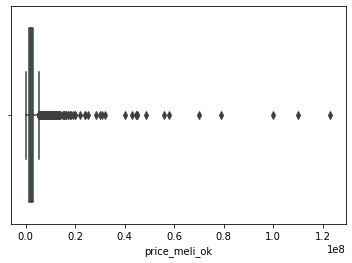

In [89]:
sns.boxplot(df_train.price_meli_ok)

In [90]:
# creamos diccionarios para guardar la info de capeo de outliers
thresh_outliers_1 = {}

In [91]:
# dropmeamos outliers globales de price
p_995 = df_train.price_meli_ok.quantile(0.995)
# guardamos la info de train para luego aplicarla en test
thresh_outliers_1['price_p995'] = p_995
mask = df_train.price_meli_ok <= p_995
df_train = df_train[mask]

<AxesSubplot:xlabel='price_meli_ok'>

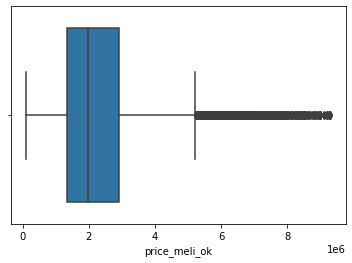

In [92]:
sns.boxplot(df_train.price_meli_ok)

In [93]:
df_train.price_meli_ok.describe(percentiles=[0.001,0.01,0.05,0.1,0.25,0.75,0.99])

count     30020.00
mean    2355410.23
std     1426974.12
min      100000.00
0.1%     480000.00
1%       650000.00
5%       850000.00
10%      950000.00
25%     1350000.00
50%     1980000.00
75%     2900000.00
99%     7550000.00
max     9300000.00
Name: price_meli_ok, dtype: float64

<AxesSubplot:xlabel='price_meli_ok', ylabel='Density'>

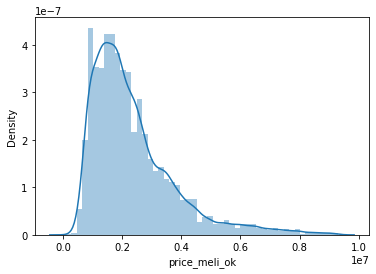

In [94]:
sns.distplot(df_train.price_meli_ok)

In [95]:
# Observamos los casos --> Podemos ver que hay casos como una Kangoo, KA, etc con precios absurdamente altos.
## Casos de este tipo trataremos en el tratamiento de outliers nº2
p_99 = df_train.price_meli_ok.quantile(0.99)
mask = df_train.price_meli_ok >= p_99
df_train[mask][model_features]

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,match_v1_c,Subseg_a,Seg_a
19561,2014,115,JEEP,Grand Cherokee,Limited 3.6 V6 AT (286hp) (L11),LIMITED,SUV 4X4,SUV
35295,2021,2900,TOYOTA,Corolla Cross,2.0 CVT SEG,2.0 SEG CVT MY21,SUV 4X2,SUV
26384,2020,20000,BMW,X1,18i sDrive Active (140cv),SDRIVE 18I,SUV Premium,SUV
12361,2017,110000,TOYOTA,Hilux,4x4 CD SRV 2.8 TDI 6AT Limited (177cv) (L16),4X4,Pickups Medianas-Grandes,Livianos
14269,2021,40000,NISSAN,X-Trail,Exclusive 2.5 CVT (170cv) (L18),EXCLUSIVE CVT,SUV 4X4,SUV
33715,2021,20500,TOYOTA,Hilux,4x2 CD SRX 2.8 TDI 6AT (177cv) (L18),2.8,Pickups Medianas-Grandes,Livianos
15599,2018,19000,VOLKSWAGEN,Tiguan Allspace,2.0 TSi Highline DSG 4Motion (220cv),2.0 TSI,SUV 4X4,SUV
22496,2019,65000,VOLKSWAGEN,Amarok,3.0 TDI V6 (224cv) 4x4 C/Doble Extreme AT (L17),DC V6 EXTREME 3.0L TDI 4X4 A,Pickups Medianas-Grandes,Livianos
22501,2019,170000,VOLKSWAGEN,Amarok,3.0 TDI V6 (224cv) 4x4 C/Doble Extreme AT (L17),DC V6 EXTREME 3.0L TDI 4X4 A,Pickups Medianas-Grandes,Livianos
36965,2017,36000,BMW,X1,20i sDrive SportLine (192cv),20I,SUV Premium,SUV


In [96]:
df_train.shape

(30020, 10)

*Ahora lo mismo pero para kms**

In [97]:
df_train.car_kms.describe(percentiles=[0.005, 0.01,0.25,0.75,0.99,0.995,0.998,0.999])

count      30020.00
mean      112786.49
std       116399.34
min          108.00
0.5%        1101.81
1%          3500.00
25%        64000.00
50%       103000.00
75%       150000.00
99%       310000.00
99.5%     350905.00
99.8%     430000.00
99.9%     539810.00
max     15000000.00
Name: car_kms, dtype: float64

<AxesSubplot:xlabel='car_kms'>

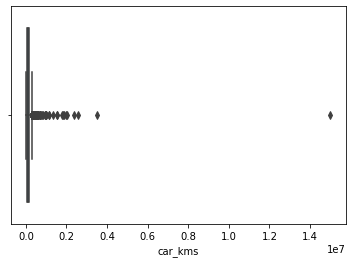

In [98]:
sns.boxplot(df_train.car_kms)

In [99]:
p_995 = df_train.car_kms.quantile(0.995)
# guardamos la info de train para luego aplicarla en test
thresh_outliers_1['kms_p995'] = p_995
mask = df_train.car_kms > p_995
len(df_train[mask])

151

In [100]:
# dropeamos outliers globales de car_kms
df_train = df_train[~mask]

In [101]:
# We are now able to save the dict with the information learned in the train set regarding the thresholds to cap outliers
import json
with open(f'{path_save}thresh_outliers_1.json', 'w') as fp:
    json.dump(thresh_outliers_1, fp)

<AxesSubplot:xlabel='car_kms'>

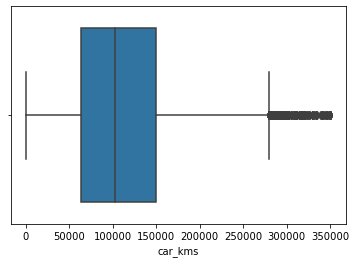

In [102]:
sns.boxplot(df_train.car_kms)

*Revision valores extremos o raros en car_year*

In [103]:
df_train.car_year.describe(percentiles=[0.005, 0.01,0.25,0.75,0.99,0.998,0.999])

count   29869.00
mean     2013.61
std         3.83
min      2006.00
0.5%     2006.00
1%       2006.00
25%      2011.00
50%      2014.00
75%      2017.00
99%      2021.00
99.8%    2021.00
99.9%    2021.00
max      2021.00
Name: car_year, dtype: float64

Vemos que no hay outliers ni casos raros en la variable de año

In [104]:
sorted(df_train.car_year.unique().tolist())

[2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021]

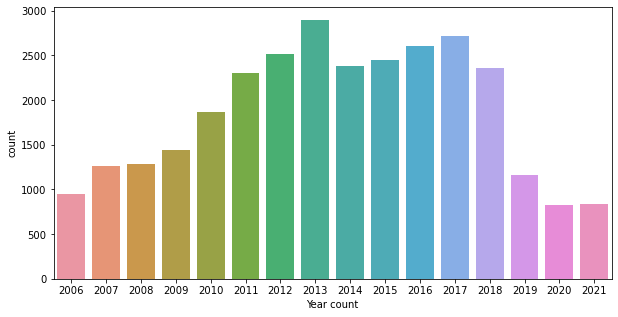

In [105]:
# plot distribution
fig = plt.figure(figsize = (10, 5))
sns.countplot(df_train.car_year)
plt.xlabel("Year count")
plt.show()

In [106]:
df_train['car_year'] = df_train['car_year'].astype('int')

***Fin del tratamiento de outliers nº1***

# Univariado + Bivariado + Cleaning

* Luego volver a correr este bivariado pero sumandole el nivel año a la agregación, luego y hacer una funcion que capee los valores que traspasen los whiskers en cada agrupacion (ej: toyota - hilux - 2020) tanto para km como para precios.
* Usar la version acara en lugarde la de camval
* Mirar los errores en la perfo del modelo, no solo el R2 (la func evaluate que use para airtm)

Esta seccion fue eliminada por fines practicos

---

### *Tratamiento de outliers nº2*
* Es un tratamiento profundo donde buscamos **outliers por contexto** (outliers a nivel de agg marca-modelo-año)
* Notar que se hace despues del Split sobre el train, para evitar data leakage! Es decir: fit_transform sobre train y transform sobre test
* Luego lo aplicaremos sobre test pero con los thresholds de outliers aprendidos en train.

In [107]:
df_train['car_year'].dtype

dtype('int64')

In [108]:
# Dropeamos todos los outliers por contexo: "Tratamiento de outliers nº2"

modelos = sorted(list(df_train.match_modelo_a.unique()))
años = sorted(list(df_train.car_year.unique()))
kms_thresh_outliers = {}
price_thresh_outliers = {}
old_shape = df_train.shape[0]
for m in modelos:
    for a in años:
        # print(f'{m} of {a}') --> solo para chequear que el loop este iterando correctamente (esta OK :)
        
        modelo_año = m + '_' + str(a)
        
        
        # kms
        mask1 = df_train.match_modelo_a == m
        mask2 = df_train.car_year == a
        data = df_train[mask1 & mask2].copy()
        
        q1 = data.car_kms.quantile(0.25)
        q3 = data.car_kms.quantile(0.75)
        IQR = q3 - q1
        outl_thresh_superior = q3+3*IQR
        outl_thresh_inferior = q1-3*IQR
        kms_thresh_outliers[modelo_año] = (outl_thresh_inferior,outl_thresh_superior)
        filt_mask_sup = data.car_kms>kms_thresh_outliers[modelo_año][1]
        filt_mask_inf = data.car_kms<kms_thresh_outliers[modelo_año][0]
        data = data[~(filt_mask_sup | filt_mask_inf)]
        df_train = df_train.loc[~(mask1 & mask2),:]
        df_train = pd.concat([df_train,data],0)
        
        # price
        mask1 = df_train.match_modelo_a == m
        mask2 = df_train.car_year == a
        data = df_train[mask1 & mask2].copy()
        
        q1 = data.price_meli_ok.quantile(0.25)
        q3 = data.price_meli_ok.quantile(0.75)
        IQR = q3 - q1
        outl_thresh_superior = q3+3*IQR
        outl_thresh_inferior = q1-3*IQR
        price_thresh_outliers[modelo_año] = (outl_thresh_inferior,outl_thresh_superior)
        filt_mask_sup = data.price_meli_ok>price_thresh_outliers[modelo_año][1]
        filt_mask_inf = data.price_meli_ok<price_thresh_outliers[modelo_año][0]
        data = data[~(filt_mask_sup | filt_mask_inf)]
        df_train = df_train.loc[~(mask1 & mask2),:]
        df_train = pd.concat([df_train,data],0)

print(f'Hey! {old_shape - df_train.shape[0]} were removed from df_train due to outliers under context')        

Hey! 326 were removed from df_train due to outliers under context


In [109]:
kms_thresh_outliers

{'2008_2006': (nan, nan),
 '2008_2007': (nan, nan),
 '2008_2008': (nan, nan),
 '2008_2009': (nan, nan),
 '2008_2010': (nan, nan),
 '2008_2011': (nan, nan),
 '2008_2012': (nan, nan),
 '2008_2013': (nan, nan),
 '2008_2014': (nan, nan),
 '2008_2015': (nan, nan),
 '2008_2016': (-11000.0, 148250.0),
 '2008_2017': (-43000.0, 163500.0),
 '2008_2018': (-55500.0, 144000.0),
 '2008_2019': (-6500.0, 63500.0),
 '2008_2020': (-27650.0, 61425.0),
 '2008_2021': (-34000.0, 57000.0),
 '206_2006': (-42017.5, 384440.0),
 '206_2007': (-29245.0, 370560.0),
 '206_2008': (-86000.0, 390000.0),
 '206_2009': (-39750.0, 362750.0),
 '206_2010': (-58000.0, 334000.0),
 '206_2011': (-49550.0, 341225.0),
 '206_2012': (-32750.0, 267375.0),
 '206_2013': (nan, nan),
 '206_2014': (nan, nan),
 '206_2015': (nan, nan),
 '206_2016': (nan, nan),
 '206_2017': (nan, nan),
 '206_2018': (nan, nan),
 '206_2019': (nan, nan),
 '206_2020': (nan, nan),
 '206_2021': (nan, nan),
 '207_2006': (nan, nan),
 '207_2007': (125000.0, 125000.0)

**Chequeos**

In [110]:
df_train.shape

(29543, 10)

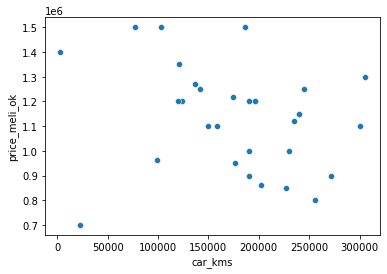

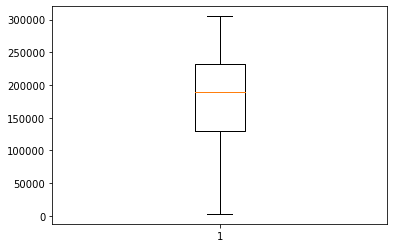

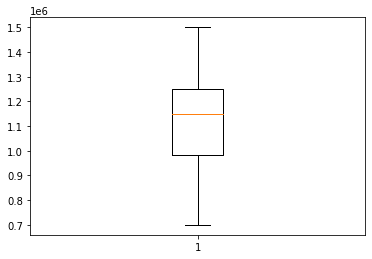

In [111]:
mask1 =df_train.match_marca_a == 'RENAULT'
mask2 =df_train.match_modelo_a == 'Kangoo'
mask3 =df_train.car_year == 2009

sns.scatterplot(df_train[mask1 & mask2 & mask3]['car_kms'],df_train[mask1 & mask2 & mask3]['price_meli_ok']);
plt.show()
plt.boxplot(df_train[mask1 & mask2 & mask3]['car_kms'])
plt.show()
plt.boxplot(df_train[mask1 & mask2 & mask3]['price_meli_ok'],)
plt.show()

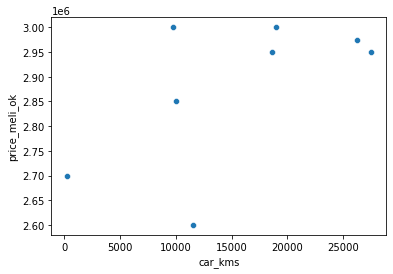

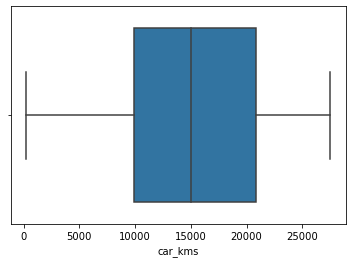

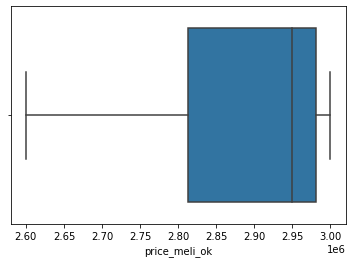

In [112]:
mask1 =df_train.match_marca_a == 'TOYOTA'
mask2 =df_train.match_modelo_a == 'Etios'
mask3 =df_train.car_year == 2019
#mask3 =df_train.match_v1_a == '1.6 3Ptas. Trendline / Pack I (101cv) '

sns.scatterplot(df_train[mask1 & mask2 & mask3]['car_kms'],df_train[mask1 & mask2 & mask3]['price_meli_ok']);
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['car_kms'])
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['price_meli_ok'],)
plt.show()

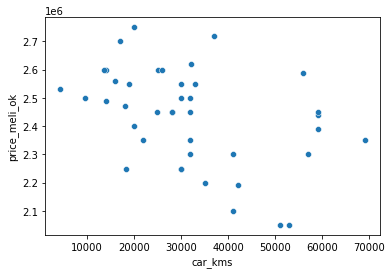

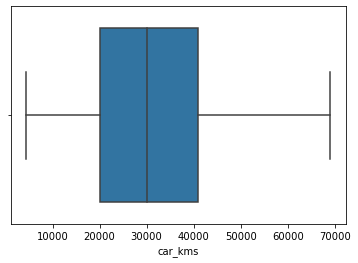

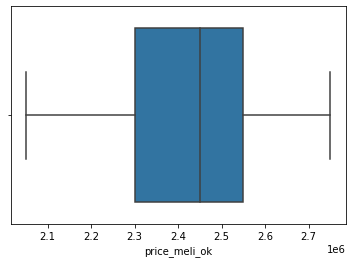

In [113]:
mask1 =df_train.match_marca_a == 'VOLKSWAGEN'
mask2 =df_train.match_modelo_a == 'Gol Trend'
mask3 =df_train.car_year == 2019
#mask3 =df_train.match_v1_a == '1.6 3Ptas. Trendline / Pack I (101cv) '

sns.scatterplot(df_train[mask1 & mask2 & mask3]['car_kms'],df_train[mask1 & mask2 & mask3]['price_meli_ok']);
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['car_kms'])
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['price_meli_ok'],)
plt.show()

In [114]:
mask1 = df_train.match_modelo_a == 'Gol Trend'
mask2 = df_train.car_year == 2019
data = df_train[mask1 & mask2].copy()
q1 = data.price_meli_ok.quantile(0.25)
q3 = data.price_meli_ok.quantile(0.75)
IQR = q3 - q1
outl_thresh_superior = q3+1.5*IQR
print(outl_thresh_superior)
print(len(data[data.price_meli_ok>outl_thresh_superior]))

2925000.0
0


Si bien es cierto que siguen apareciendo outliers, esto es normal debido a que con el tratamiento que hicimos la distribucion cambia y es logico que ahora un valor que antes no se consideraba outliers si se considere. Lo bueno es que ahora estos outliers ya no son tan extremos e irriorios.

In [115]:
price_thresh_outliers

{'2008_2006': (nan, nan),
 '2008_2007': (nan, nan),
 '2008_2008': (nan, nan),
 '2008_2009': (nan, nan),
 '2008_2010': (nan, nan),
 '2008_2011': (nan, nan),
 '2008_2012': (nan, nan),
 '2008_2013': (nan, nan),
 '2008_2014': (nan, nan),
 '2008_2015': (nan, nan),
 '2008_2016': (1837500.0, 3500000.0),
 '2008_2017': (1500000.0, 4300000.0),
 '2008_2018': (1280000.0, 5060000.0),
 '2008_2019': (2450000.0, 4900000.0),
 '2008_2020': (1122500.0, 6757500.0),
 '2008_2021': (3350000.0, 5450000.0),
 '206_2006': (330000.0, 1310000.0),
 '206_2007': (390000.0, 1282500.0),
 '206_2008': (550000.0, 1250000.0),
 '206_2009': (375000.0, 1267500.0),
 '206_2010': (130000.0, 1810000.0),
 '206_2011': (591250.0, 1300000.0),
 '206_2012': (587500.0, 1550000.0),
 '206_2013': (nan, nan),
 '206_2014': (nan, nan),
 '206_2015': (nan, nan),
 '206_2016': (nan, nan),
 '206_2017': (nan, nan),
 '206_2018': (nan, nan),
 '206_2019': (nan, nan),
 '206_2020': (nan, nan),
 '206_2021': (nan, nan),
 '207_2006': (nan, nan),
 '207_2007

In [116]:
# Guardamos los diccionarios con la info de outiers thresholds en formato json
with open('{}kms_thresh_outliers.json'.format(path_save), 'w') as outfile:
    json.dump(kms_thresh_outliers, outfile)

with open('{}price_thresh_outliers.json'.format(path_save), 'w') as outfile:
    json.dump(price_thresh_outliers, outfile)

Notesé que en muchos casos nos quedan "nan", eso es porque aveces no tenemos ningun registro de un marca-modelo para un cierto año en particular (ej: talvez no se fabrico ese modelo durante ese año o cosas así). Por lo único que tendremos que tener cuidado es cuando apliquemos este cleaning sobre test, vamos a tener que poner un "if" que haga un "pass" en caso de que los thresh seas "nan"

In [117]:
df_train.to_csv('{}df_train_checkpoint_4.pkl'.format(path_save)) # este es el df_train final!
# el test sigue igual

# Applying data cleaning in the test set

In [118]:
df_train_ok = pd.read_csv('{}df_train_checkpoint_4.pkl'.format(path_save))

In [119]:
df_test = pd.read_csv('{}df_test_checkpoint_3.pkl'.format(path_save))

In [120]:
print(df_train_ok.shape)
print(df_test.shape)

(29543, 11)
(7543, 11)


In [121]:
# Aplicamos el data cleaning aprendido en train sobre el set de test para usarlo en la evaluacion
df_test_ok = cleaning_after_split(df_test,path_save)

Hey! 84 were removed due to outliers globales
Hey! 288 were removed from df due to outliers under context


In [122]:
df_test_ok.shape

(7171, 11)

In [123]:
df_test_ok['marca_modelo_version'] = df_test_ok['match_marca_a'] + str(' - ') +df_test_ok['match_modelo_a'] + str(' - ') + df_test_ok['match_v1_a']

old_shape = df_test_ok.shape[0]

marc_mod_vers_OK = pd.read_csv('{}marc_mod_vers_OK.csv'.format(path_save), index_col=[0])
marc_mod_vers_OK = list(marc_mod_vers_OK.iloc[:,0])
mask = df_test_ok.marca_modelo_version.apply(lambda x: x in marc_mod_vers_OK)
df_test_ok = df_test_ok[mask]

In [124]:
print(f'Hey! {old_shape - df_test_ok.shape[0]} were removed due to categories in which we are not interested in score')

Hey! 3123 were removed due to categories in which we are not interested in score


In [125]:
df_test_ok.shape

(4048, 12)

In [126]:
df_test_ok.to_csv('{}df_test_checkpoint_4.pkl'.format(path_save)) # este es el df_test final!

In [127]:
#df_test_ok = pd.read_csv('{}df_test_checkpoint_4.pkl'.format(path_save))
#df_test_ok.shape

### Save the IDs that we've used in dev

In [128]:
display(df_train_ok.car_id.nunique()
        ,df_test_ok.car_id.nunique())

29543

4048

In [129]:
# We can see that they are completely different
display(len(list(set(df_train_ok.car_id.unique()).difference(set(df_test_ok.car_id.unique()))))
        ,len(list(set(df_test_ok.car_id.unique()).difference(set(df_train_ok.car_id.unique()))))
       )

29543

4048

In [130]:
ids_dev = list(df_train_ok.car_id.unique()) + list(df_test_ok.car_id.unique())
len(ids_dev)

33591

In [131]:
len(set(ids_dev))

33591

In [132]:
df_ids_dev = pd.DataFrame(ids_dev, columns=['car_id_dev'])
df_ids_dev.to_csv('{}df_ids_dev.pkl'.format(path_save))

# Modelling

In [133]:
model_features = ['car_year','car_kms','match_marca_a','match_modelo_a','match_v1_a','Subseg_a', 'Seg_a']

In [134]:
# Volvemos a separar en X e y
X_train = df_train_ok[model_features]
y_train = df_train_ok.price_meli_ok

X_test = df_test_ok[model_features]
y_test = df_test_ok.price_meli_ok

## Modelo Baseline

In [135]:
X_train.columns

Index(['car_year', 'car_kms', 'match_marca_a', 'match_modelo_a', 'match_v1_a',
       'Subseg_a', 'Seg_a'],
      dtype='object')

In [136]:
# Recordar agregar esto en la funcion de procesamiento para la simulacion

# Cuando hice el tratamiento de 1111 y 99999 había pasado la feature de kms a int. Volvemos a pasar a float por el catboost
X_train['car_kms'] = X_train['car_kms'].astype('float')
X_test['car_kms'] = X_test['car_kms'].astype('float')

# probamos tanto usando year como int y como float y la perfo del modelo dio apenas mejor con year en float
X_train['car_year'] = X_train['car_year'].astype('float')
X_test['car_year'] = X_test['car_year'].astype('float')

In [137]:
X_train.dtypes

car_year          float64
car_kms           float64
match_marca_a      object
match_modelo_a     object
match_v1_a         object
Subseg_a           object
Seg_a              object
dtype: object

In [138]:
np.where(X_train[model_features].dtypes != np.float)[0]

array([2, 3, 4, 5, 6])

In [139]:
# model=CatBoostRegressor(loss_function='RMSE',logging_level="Silent")
# categorical_features_indices = np.where(X_train[model_features].dtypes != np.float)[0]
# model.fit(X_train, y_train, cat_features=categorical_features_indices)#, eval_set=(X_test, y_test))

# train_pred = model.predict(X_train)
# test_pred = model.predict(X_test)

# print('Train set evaluation:\n_____________________________________')
# print_evaluate(y_train, train_pred)
# print('Test set evaluation:\n_____________________________________')
# print_evaluate(y_test, test_pred)

In [140]:
# model.get_feature_importance(prettified=True)

In [141]:
model=CatBoostRegressor(loss_function='RMSE',logging_level="Silent")
categorical_features_indices = np.where(X_train[model_features].dtypes != np.float)[0]
model.fit(X_train, y_train, cat_features=categorical_features_indices)#, eval_set=(X_test, y_test))

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

Train set evaluation:
_____________________________________
MAE: 196248.29967615107
MAPE: 9.103344422814466
MEDAPE: 6.803573073005101
MSE: 90138496235.84732
RMSE: 300230.7383261203
R2 Square 0.9554316190304796
__________________________________
Test set evaluation:
_____________________________________
MAE: 183566.99858924616
MAPE: 8.433814137211604
MEDAPE: 6.382002892923774
MSE: 75582341799.93182
RMSE: 274922.42869568104
R2 Square 0.9635524531976678
__________________________________


In [142]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,car_year,32.41
1,Subseg_a,25.97
2,match_marca_a,12.58
3,match_modelo_a,11.58
4,Seg_a,7.65
5,car_kms,5.08
6,match_v1_a,4.73


In [143]:
# Save del modelo fiteado

path_model_save = '../model/'

import pickle
with open('{}model_catboost_v4_allgroups.pickle'.format(path_model_save), 'wb') as f:
    pickle.dump(model, f)

---

## Validacion OOT (IDs nuevos!)
fecha de la corrida: 4 de mayo

In [144]:
# Importar tabla de Big Query
query = '''SELECT *
           FROM `data-team-k.pricing_data.match_meli_ok`
           WHERE date between "2022-04-26" and "2022-05-03"
            '''
df_scoreo_oot = gbq.read_gbq(query, project_id="data-team-k")

KeyboardInterrupt: 

In [ ]:
df_scoreo_oot.shape

In [ ]:
# checkpoint upload
df_scoreo_oot.to_csv('{}df_score_oot_IDsnuevos_mayor_2604.csv'.format(path_save))

In [145]:
# checkpoint upload
df_scoreo_oot = pd.read_csv('{}df_score_oot_IDsnuevos_mayor_2604.csv'.format(path_save))

In [146]:
df_scoreo_oot.shape

(861914, 43)

In [147]:
# chequeo
print(len(df_scoreo_oot))
print(df_scoreo_oot.date.min(), df_scoreo_oot.date.max())

861914
2022-04-26 2022-05-03


In [148]:
# Creamos la feature marca_modelo_version ya que necesitamos tenerla en el df para las funciones de limpieza
df_scoreo_oot['marca_modelo_version'] = df_scoreo_oot['match_marca_a'] + str(' - ') +df_scoreo_oot['match_modelo_a'] + str(' - ') + df_scoreo_oot['match_v1_a']

In [149]:
# aplicamos la limpieza pre split
df_scoreo_oot = cleaning_before_split(df_scoreo_oot)

Hey! 38 were removed due to null values
Hey! 741463 were removed due to duplicate values
Hey! 913 were removed due those 11111 or 9999 strange values
Hey! 13452 were removed due prices in dollars
Hey! 60664 were removed due to 0km or concesioarias
Hey! 14142 were removed due to match scores under 80%
Hey! 0 were removed due to last 15d filter
Hey! 15100 were removed due to categories in which we are not interested in score


In [150]:
df_scoreo_oot.shape

(16142, 13)

In [151]:
# aplicamos la limpieza post split
df_scoreo_oot = cleaning_after_split(df_scoreo_oot,path_save)

Hey! 136 were removed due to outliers globales
Hey! 175 were removed from df due to outliers under context


In [152]:
df_scoreo_oot.shape

(15831, 13)

In [153]:
# Eliminamos los car_id que ya hayamos usado para entrenar
ids_dev = list(df_ids_dev.car_id_dev.unique())
mask = df_scoreo_oot.car_id.apply(lambda x: x not in ids_dev)
df_scoreo_oot[mask].shape

(5110, 13)

In [154]:
model_features = ['car_year','car_kms','match_marca_a','match_modelo_a','match_v1_a','Subseg_a', 'Seg_a']

In [155]:
import pickle
path_model = '../model/'
with open('{}model_catboost_v4_allgroups.pickle'.format(path_model), 'rb') as f:
    model = pickle.load(f)

In [156]:
X_oot = df_scoreo_oot[model_features].copy()
y_oot = df_scoreo_oot.price_meli_ok.copy()

In [157]:
nos quedamos aca

SyntaxError: invalid syntax (703021635.py, line 1)

In [158]:
# Assesment
oot_pred = model.predict(X_oot)

print('OOT set evaluation:\n_____________________________________')
print_evaluate(y_oot, oot_pred)

OOT set evaluation:
_____________________________________
MAE: 174288.76431825486
MAPE: 8.0232580019103
MEDAPE: 6.236289085968486
MSE: 66056038549.84351
RMSE: 257013.69331193916
R2 Square 0.9610871154449352
__________________________________


### Model assesment (on validation/oot set)

In [159]:
oot_pred = pd.Series(oot_pred,name='oot_pred')
d = pd.concat([X_oot.reset_index(drop=True), y_oot.reset_index(drop=True), oot_pred],1)

In [160]:
d.head()

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,price_meli_ok,oot_pred
0,2021.00,1900,HONDA,Fit,1.5 EX CVT IVTEC (120cv) (L18),Monovolumen Compacto,Monovolumen,4980000,4877954.86
1,2016.00,79900,RENAULT,Captur,2.0 16v 6MT Intens Bitono Nav. Evo. (143cv),Suv Compactas 4x2,SUV,3570000,3115552.70
2,2013.00,126000,PEUGEOT,206,5Ptas. 1.4 Active / EdG Géneration,Gama Pequenos Hatchback,Gama Pequenos,1220000,1291559.80
3,2020.00,204000,RENAULT,Sandero Stepway,Fase II 1.6 16v Expression / Confort ABCP ABS ...,Gama Pequenos Hatchback,Gama Pequenos,1200000,2537676.39
4,2018.00,15561,FIAT,Uno,Fire 1.3 Pack C / Way (68cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,2100000,2066488.28


In [161]:
y_val = d['price_meli_ok']
deciles_y_true = y_val.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

dic = {}
for i in range(1,10+1):
    dic['d{}'.format(i)] = deciles_y_true.values[i-1]

In [162]:
dic

{'d1': 1050000.0,
 'd2': 1300000.0,
 'd3': 1500000.0,
 'd4': 1750000.0,
 'd5': 2000000.0,
 'd6': 2300000.0,
 'd7': 2600000.0,
 'd8': 3200000.0,
 'd9': 3990000.0,
 'd10': 9300000.0}

In [163]:
# We discretize the vector of true labels to see it in deciles
d['y_true_disc'] = np.where(y_val <= dic['d1'], 'd01',
                       np.where((y_val > dic['d1']) & (y_val <= dic['d2']), 'd02',
                               np.where((y_val > dic['d2']) & (y_val <= dic['d3']), 'd03',
                                       np.where((y_val > dic['d3']) & (y_val <= dic['d4']), 'd04',
                                               np.where((y_val > dic['d4']) & (y_val <= dic['d5']), 'd05',
                                                       np.where((y_val > dic['d5']) & (y_val <= dic['d6']), 'd06',
                                                               np.where((y_val > dic['d6']) & (y_val <= dic['d7']), 'd07',
                                                                       np.where((y_val > dic['d7']) & (y_val <= dic['d8']), 'd08',
                                                                               np.where((y_val > dic['d8']) & (y_val <= dic['d9']), 'd09',
                                                                                       np.where((y_val > dic['d9']) & (y_val <= dic['d10']), 'd10','out_of_bounds'))))))))))

In [164]:
d.head(10)

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,price_meli_ok,oot_pred,y_true_disc
0,2021.00,1900,HONDA,Fit,1.5 EX CVT IVTEC (120cv) (L18),Monovolumen Compacto,Monovolumen,4980000,4877954.86,d10
1,2016.00,79900,RENAULT,Captur,2.0 16v 6MT Intens Bitono Nav. Evo. (143cv),Suv Compactas 4x2,SUV,3570000,3115552.70,d09
2,2013.00,126000,PEUGEOT,206,5Ptas. 1.4 Active / EdG Géneration,Gama Pequenos Hatchback,Gama Pequenos,1220000,1291559.80,d02
3,2020.00,204000,RENAULT,Sandero Stepway,Fase II 1.6 16v Expression / Confort ABCP ABS ...,Gama Pequenos Hatchback,Gama Pequenos,1200000,2537676.39,d02
4,2018.00,15561,FIAT,Uno,Fire 1.3 Pack C / Way (68cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,2100000,2066488.28,d06
5,2006.00,64000,VOLKSWAGEN,Up,1.0 High Up! (75cv) 3Ptas.,Gama Pequenos Hatchback,Gama Pequenos,2000000,1004768.61,d05
6,2016.00,79900,RENAULT,Captur,2.0 16v 6MT Intens Bitono Nav. Evo. (143cv),Suv Compactas 4x2,SUV,3570000,3115552.70,d09
7,2016.00,103000,RENAULT,Captur,2.0 16v 6MT Intens Bitono Nav. Evo. (143cv),Suv Compactas 4x2,SUV,3280000,3035873.42,d09
8,2013.00,130000,PEUGEOT,2008,1.6 16v. Feline Tiptronic (115cv) (L20),Suv Compactas 4x2,SUV,1300000,1811849.25,d02
9,2015.00,50000,VOLKSWAGEN,Bora,2.0 Trendline MT,Gama Medianos Sedan,Gama Medianos,2000000,2311633.15,d05


In [165]:
# Accuracy
d['menos10perc'] = d.oot_pred * 0.9
d['mas10perc'] = d.oot_pred * 1.1
d['menos10perc'] = d['menos10perc'].astype('int')
d['mas10perc'] = d['mas10perc'].astype('int')
d['falls_in_range'] = np.where(
    (d['price_meli_ok']>=d['menos10perc']) & (d['price_meli_ok']<=d['mas10perc']),1,0)

In [166]:
d.head()

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,price_meli_ok,oot_pred,y_true_disc,menos10perc,mas10perc,falls_in_range
0,2021.00,1900,HONDA,Fit,1.5 EX CVT IVTEC (120cv) (L18),Monovolumen Compacto,Monovolumen,4980000,4877954.86,d10,4390159,5365750,1
1,2016.00,79900,RENAULT,Captur,2.0 16v 6MT Intens Bitono Nav. Evo. (143cv),Suv Compactas 4x2,SUV,3570000,3115552.70,d09,2803997,3427107,0
2,2013.00,126000,PEUGEOT,206,5Ptas. 1.4 Active / EdG Géneration,Gama Pequenos Hatchback,Gama Pequenos,1220000,1291559.80,d02,1162403,1420715,1
3,2020.00,204000,RENAULT,Sandero Stepway,Fase II 1.6 16v Expression / Confort ABCP ABS ...,Gama Pequenos Hatchback,Gama Pequenos,1200000,2537676.39,d02,2283908,2791444,0
4,2018.00,15561,FIAT,Uno,Fire 1.3 Pack C / Way (68cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,2100000,2066488.28,d06,1859839,2273137,1


In [167]:
# Overall Accuracy
d.falls_in_range.mean()

0.7049459920409323

In [168]:
# Accuracy by decile
acc_by_dec = d.groupby('y_true_disc')['falls_in_range'].mean().reset_index()
acc_by_dec

,y_true_disc,falls_in_range
0,d01,0.51
1,d02,0.66
2,d03,0.67
3,d04,0.70
4,d05,0.77
5,d06,0.79
6,d07,0.74
7,d08,0.75
8,d09,0.75
9,d10,0.71


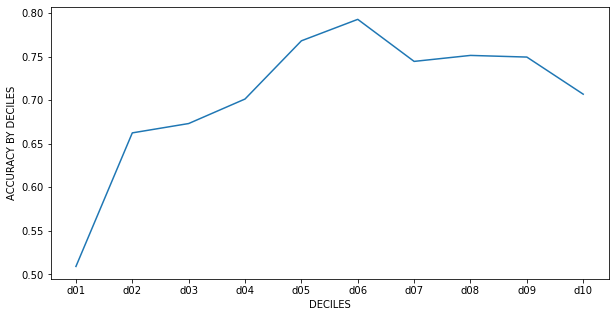

In [ ]:
# plot distribution
fig = plt.figure(figsize = (10, 5))
plt.plot(acc_by_dec['y_true_disc'], acc_by_dec['falls_in_range'])
plt.xlabel("DECILES")
plt.ylabel("ACCURACY BY DECILES")
plt.show()

### Final Output

In [170]:
extra_features = ['car_id','match_v1_c','car_location_1']
data_output = pd.concat([df_scoreo_oot[extra_features].reset_index(drop=True)
                         ,X_oot.reset_index(drop=True)
                         ,pd.Series(y_oot,name='y_oot').reset_index(drop=True)
                         ,pd.Series(oot_pred,name='oot_pred')],1)
data_output

# faltaría sumarle una que indique el grupo de presencialidad (previo a eso re-entrenar sumando grupo 2 y 3 y ver como impacta en la perfo)

,car_id,match_v1_c,car_location_1,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,y_oot,oot_pred
0,1131678653,EX,Neuquén,2021.00,1900,HONDA,Fit,1.5 EX CVT IVTEC (120cv) (L18),Monovolumen Compacto,Monovolumen,4980000,4877954.86
1,1125544164,INTENS 2.0,Bs.As. G.B.A. Norte,2016.00,79900,RENAULT,Captur,2.0 16v 6MT Intens Bitono Nav. Evo. (143cv),Suv Compactas 4x2,SUV,3570000,3115552.70
2,1125548551,ACTIVE 1.4 N 5P,Bs.As. G.B.A. Oeste,2013.00,126000,PEUGEOT,206,5Ptas. 1.4 Active / EdG Géneration,Gama Pequenos Hatchback,Gama Pequenos,1220000,1291559.80
3,1133503494,"5P 1,6 16V CONFORT 2013",Río Negro,2020.00,204000,RENAULT,Sandero Stepway,Fase II 1.6 16v Expression / Confort ABCP ABS ...,Gama Pequenos Hatchback,Gama Pequenos,1200000,2537676.39
4,1131159819,"5P 1,3 WAY 2018",Bs.As. G.B.A. Sur,2018.00,15561,FIAT,Uno,Fire 1.3 Pack C / Way (68cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,2100000,2066488.28
...,...,...,...,...,...,...,...,...,...,...,...,...
15826,1129453820,"4P 1,6 COMFORTLINE",Bs.As. G.B.A. Oeste,2015.00,68000,VOLKSWAGEN,Voyage,1.6 Trendline / Comfortline (101cv) (MY14 ABG ...,Gama Pequenos Sedan,Gama Pequenos,1750000,1729297.57
15827,1129497150,"4P 1,6 COMFORTLINE",Capital Federal,2015.00,148000,VOLKSWAGEN,Voyage,1.6 Trendline / Comfortline (101cv) (MY14 ABG ...,Gama Pequenos Sedan,Gama Pequenos,1500000,1514235.40
15828,1130206778,"4P 1,6 COMFORTLINE",Bs.As. G.B.A. Sur,2015.00,139000,VOLKSWAGEN,Voyage,1.6 Trendline / Comfortline (101cv) (MY14 ABG ...,Gama Pequenos Sedan,Gama Pequenos,1700000,1544902.45
15829,1135330342,"4P 1,6 COMFORTLINE",Bs.As. G.B.A. Norte,2015.00,153000,VOLKSWAGEN,Voyage,1.6 Trendline / Comfortline (101cv) (MY14 ABG ...,Gama Pequenos Sedan,Gama Pequenos,1600000,1495563.00


In [171]:
# chequeo (tiene que mantenerse igual que el anterior) -- OK
print('OOT set evaluation:\n_____________________________________')
print_evaluate(data_output.y_oot, data_output.oot_pred)

OOT set evaluation:
_____________________________________
MAE: 174288.76431825486
MAPE: 8.0232580019103
MEDAPE: 6.236289085968486
MSE: 66056038549.84351
RMSE: 257013.69331193916
R2 Square 0.9610871154449352
__________________________________


In [172]:
# Worst MAPE
data_output['mape'] = (abs(data_output['y_oot'] - data_output['oot_pred']) / y_oot)

In [173]:
data_output.head()

,car_id,match_v1_c,car_location_1,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,y_oot,oot_pred,mape
0,1131678653,EX,Neuquén,2021.00,1900,HONDA,Fit,1.5 EX CVT IVTEC (120cv) (L18),Monovolumen Compacto,Monovolumen,4980000,4877954.86,NaN
1,1125544164,INTENS 2.0,Bs.As. G.B.A. Norte,2016.00,79900,RENAULT,Captur,2.0 16v 6MT Intens Bitono Nav. Evo. (143cv),Suv Compactas 4x2,SUV,3570000,3115552.70,NaN
2,1125548551,ACTIVE 1.4 N 5P,Bs.As. G.B.A. Oeste,2013.00,126000,PEUGEOT,206,5Ptas. 1.4 Active / EdG Géneration,Gama Pequenos Hatchback,Gama Pequenos,1220000,1291559.80,NaN
3,1133503494,"5P 1,6 16V CONFORT 2013",Río Negro,2020.00,204000,RENAULT,Sandero Stepway,Fase II 1.6 16v Expression / Confort ABCP ABS ...,Gama Pequenos Hatchback,Gama Pequenos,1200000,2537676.39,NaN
4,1131159819,"5P 1,3 WAY 2018",Bs.As. G.B.A. Sur,2018.00,15561,FIAT,Uno,Fire 1.3 Pack C / Way (68cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,2100000,2066488.28,NaN


In [176]:
data_output['mape'].max()

0.5747122272656251

In [178]:
data_output['mape'].describe(percentiles=[0.1,0.25,0.5,0.75,0.8,0.9,0.95,0.97,.99])

count   69.00
mean     0.10
std      0.11
min      0.00
10%      0.01
25%      0.03
50%      0.06
75%      0.13
80%      0.16
90%      0.27
95%      0.34
97%      0.36
99%      0.44
max      0.57
Name: mape, dtype: float64

Esto es muy bueno, y quiere decir que en un 90% de los casos el mape es menos al 27%. O mirando el p80 podemos decir que en un 80% de los casos el mape es menor al 16%

Encima hay que tener en cuenta que este es el test usando en el train todos los casos de baja presencia lo cual como vimos empeora un poco nuestras metricas de perfomance. Por lo tanto seguramente en el modelo donde entrenamos solo con los que nos interesa scorear vamos a tener aun mejores resultados en este describe() del mape per row

---
Fin